In [1]:
#### Import all required models and flows ####

import re
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix, hstack, csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#readability
import textstat

#sytax
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/avinashc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/avinashc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
#### Helper functions used later ####
def cleanArticle(string):
    strip_special_chars = re.compile("[^A-Za-z0-9' ]+")
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

#### Read the dataset into a dataframe for further processing ####
def read_dataset(dataset_name):
    
    def remove_numbers(in_str):
        return re.sub(r'[0-9]+', '', in_str)
    
    print("Reading dataset")
    result_data_list = []
    data_dir = DATASET_PATH
    for news_type in ['fake', 'legit']:
        folder = '%s/%s/%s' % (data_dir, dataset_name, news_type)
        for fname in os.listdir(folder):
            result_data = {}
            result_data['dataset_name'] = dataset_name
            result_data['news_type'] = news_type
            if news_type == 'fake':
                result_data['is_fake'] = 1
            else:
                result_data['is_fake'] = 0
            if dataset_name == 'fakeNewsDataset':
                result_data['news_category'] = remove_numbers(fname.split('.')[0])
            result_data['file_name'] = fname
            filepath = os.path.join(folder, fname)
            with open(filepath, 'r', encoding="utf8") as f:
                file_data = f.read().split('\n')
                # Some articles don't have a headline, but only article body.
                if len(file_data) > 1:
                    news_content_data = ' '.join(file_data[2:])
                    result_data['news_headline'] = file_data[0]
                else:
                    news_content_data = file_data[0]
                    result_data['news_headline'] = ''
                result_data['news_content'] = news_content_data
                result_data['news_all'] = ' '.join(file_data[0:])
                result_data_list.append(result_data)
                
    df = pd.DataFrame(result_data_list)
    
    df['news_all_clean'] = df['news_all'].apply(lambda a: cleanArticle(a))
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['is_fake','news_type','file_name'],axis = 1), 
                                                        df['is_fake'], 
                                                        test_size=.2, random_state=RANDOM_SEED)
    
    print("Finished reading dataset")
    return df, X_train.reset_index(drop=True),\
            y_train.reset_index(drop=True), X_test.reset_index(drop=True), y_test.reset_index(drop=True)

**Linguistic features helper function: Punctuation & Ngram**

In [3]:
#### Helper functions used later ####
def pad_punct(s):
    #Add padding around specified punctuation
    s = re.sub('([.,!?():])', r' \1 ', s)
    s = re.sub('\s{2,}', ' ', s)
    return s

def tfidf_vectorizer_custom(train, test, ngram_range):
    #Create a tfidf vectorized set for train and test data that counts punctuation
    train = train.apply(pad_punct)
    test = test.apply(pad_punct)
    vect = TfidfVectorizer(token_pattern=r"(?u)\b\w\w+\b|!|\.|,|\)|\(|\:|\?|\"|\'", #pattern keep punctuation in vectorizer
                          ngram_range = ngram_range).fit(train)
    vocab = vect.vocabulary_.keys()
    vocab = sorted(vocab, key=len)
    print("Training data info:")
    print('- Vocabulary len:', len(vect.get_feature_names()))
    print('- Longest phrase:', max(vect.vocabulary_, key=len))
    print('- Smallest 10 phrases:', vocab[0:10])
    print('- Sample of features:',np.array(vect.get_feature_names()))
    train_vectorized = vect.transform(train)
    test_vectorized = vect.transform(test)
    return train_vectorized, test_vectorized, vect.get_feature_names()

**Linguistic features helper function: Readability**

In [4]:
def readability_metric(df1):
    """
    Input: a dataframe with column "news_all" to be analyzed for a variety of readbility metrics.
    Output: the inputted dataframe, enriched with all readbility metrics 
            there are a total of 10, one of which is categorical
    """
    df = df1.copy()
    df_drop = df1.copy()
    df["flesch_reading_ease"]=0.0
    df["smog_index"]=0.0
    df["flesch_kincaid_grade"]=0.0
    df["coleman_liau_index"]=0.0
    df["automated_readability_index"]=0.0
    df["dale_chall_readability_score"]=0.0
    df["difficult_words"]=0.0
    df["linsear_write_formula"]=0.0
    df["gunning_fog"]=0.0
    df["text_standard"]=0.0

    for i in range(df.shape[0]):
        text = df['news_all'].iloc[i]
        df.loc[i,("flesch_reading_ease")]= textstat.flesch_reading_ease(text)
        df.loc[i,("smog_index")]= textstat.smog_index(text)
        df.loc[i,("flesch_kincaid_grade")]= textstat.flesch_kincaid_grade(text)
        df.loc[i,("coleman_liau_index")]= textstat.coleman_liau_index(text)
        df.loc[i,("automated_readability_index")]= textstat.automated_readability_index(text)
        df.loc[i,("dale_chall_readability_score")]= textstat.dale_chall_readability_score(text)
        df.loc[i,("difficult_words")]= textstat.difficult_words(text)
        df.loc[i,("linsear_write_formula")]= textstat.linsear_write_formula(text)
        df.loc[i,("gunning_fog")]= textstat.gunning_fog(text)
        df.loc[i,("text_standard")]= textstat.text_standard(text)
    
    return df

**Linguistic features helper function: Syntax**

In [5]:
def POS_tagger(text):
    # Tag POS using nltk. Return a single "sentence" with the POS of each word treated like a "word."

    tokens = nltk.word_tokenize(text)
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    return " ".join([i[1] for i in tags])

def POS_enricher(df1):
    """
    Input: a dataframe with column "news_headline" and "news_content".
    Output: the inputted dataframe, with the columns "news_headline_POS" and "news_content_POS" created 
            which are a single sentence with the POS of each word represented as word in that same position.
    """
    df = df1.copy()
    df["news_headline_POS"]=""
    df["news_content_POS"]=""
    
    for i in range(df.shape[0]):
        text_headline = cleanArticle(POS_tagger(df['news_headline'].apply(lambda a: cleanArticle(a)).iloc[i]))
        text_content = cleanArticle(POS_tagger(df['news_content'].apply(lambda a: cleanArticle(a)).iloc[i]))
        
        df.loc[i,("news_headline_POS")]= text_headline
        df.loc[i,("news_content_POS")]= text_content
    
    return df

In [6]:
# Initialize dataset area
RANDOM_SEED = 139
DATASET_PATH = "fakeNewsDatasets"
ID_UNKNOWN = 399999

news_full, news_train_data, news_train_labels, news_test_data, news_test_labels = read_dataset('fakeNewsDataset')
news_train_data.head()

Reading dataset
Finished reading dataset


,dataset_name,news_category,news_headline,news_content,news_all,news_all_clean
0,fakeNewsDataset,edu,Donald Trump's Win To The Presidency Causes Fr...,High school students spend years being taugh...,Donald Trump's Win To The Presidency Causes Fr...,donald trump's win to the presidency causes fr...
1,fakeNewsDataset,edu,Trump's Pick for Education Could Face Unusuall...,Nominees for secretary of education have typic...,Trump's Pick for Education Could Face Unusuall...,trump's pick for education could face unusuall...
2,fakeNewsDataset,biz,Macron and Le Pen Fight for Votes,"Anticipating French Election Runoff ""With more...",Macron and Le Pen Fight for Votes Anticipatin...,macron and le pen fight for votes anticipatin...
3,fakeNewsDataset,edu,Girls Who Code Closing Computer Science Gender...,It's time to close the gender gap. One of the...,Girls Who Code Closing Computer Science Gender...,girls who code closing computer science gender...
4,fakeNewsDataset,polit,,The U.S. Supreme court has done the unthinkabl...,The U.S. Supreme court has done the unthinkabl...,the us supreme court has done the unthinkable ...


In [7]:
celeb_full, celeb_train_data, celeb_train_labels, celeb_test_data, celeb_test_labels = read_dataset('celebrityDataset')
celeb_train_data.head()

Reading dataset
Finished reading dataset


,dataset_name,news_headline,news_content,news_all,news_all_clean
0,celebrityDataset,"Lady Gaga Announces Netflix Documentary, Talks...",Lady Gaga is ready to open up. The “Joanne” si...,"Lady Gaga Announces Netflix Documentary, Talks...",lady gaga announces netflix documentary talks ...
1,celebrityDataset,This Is What Brad Pitt Has Been Texting Jennif...,It has been six months since Brangelina (that'...,This Is What Brad Pitt Has Been Texting Jennif...,this is what brad pitt has been texting jennif...
2,celebrityDataset,Caitlyn Jenner Looks to New Girlfriend for Sup...,The wrath of the Kardashians is the least of C...,Caitlyn Jenner Looks to New Girlfriend for Sup...,caitlyn jenner looks to new girlfriend for sup...
3,celebrityDataset,'Girl' Fight! Kanye West Confronts Anna Wintou...,"Too big for your designed sneakers, Kanye? Dur...",'Girl' Fight! Kanye West Confronts Anna Wintou...,'girl' fight kanye west confronts anna wintour...
4,celebrityDataset,Caitlyn Jenner's Memoir Reportedly Lands Movie...,Report says that the 'How to Be a Latin Lover'...,Caitlyn Jenner's Memoir Reportedly Lands Movie...,caitlyn jenner's memoir reportedly lands movie...


**Create new Punctuation and Ngram features**

In [8]:
#1. FakeNews
news_train_data_vectorized, news_test_data_vectorized, news_ngram_punct_names = tfidf_vectorizer_custom(
    news_train_data['news_all'], news_test_data['news_all'], ngram_range = (1,2))
print("train shape:", news_train_data_vectorized.shape)

Training data info:
- Vocabulary len: 39662
- Longest phrase: fundamental misunderstanding
- Smallest 10 phrases: ["'", ',', '.', '"', ':', '!', '?', '(', ')', 'to']
- Sample of features: ['!' '! !' '! "' ... 'zuckerberg ,' 'zverev' 'zverev roger']
train shape: (384, 39662)


In [9]:
#2. Celeb
celeb_train_data_vectorized, celeb_test_data_vectorized, celeb_ngram_punct_names = tfidf_vectorizer_custom(
    celeb_train_data['news_all'], celeb_test_data['news_all'], ngram_range = (1,2))
print("train shape:", celeb_train_data_vectorized.shape)

Training data info:
- Vocabulary len: 98506
- Longest phrase: 3333333333333333333333333333333333333 triplets
- Smallest 10 phrases: [',', '.', ':', '?', '(', "'", ')', '!', '"', 'is']
- Sample of features: ['!' '! !' '! "' ... 'zucker says' 'zwang' 'zwang ,']
train shape: (400, 98506)


**Create new Readability features**

In [10]:
#1. FakeNews
news_train_data_readability = readability_metric(news_train_data)
news_test_data_readability = readability_metric(news_test_data)
print("train shape:", news_train_data_readability.shape)

train shape: (384, 16)


In [11]:
#2. Celb
celeb_train_data_readability = readability_metric(celeb_train_data)
celeb_test_data_readability = readability_metric(celeb_test_data)
print("train shape:", celeb_train_data_readability.shape)

train shape: (400, 15)


**Create new Syntax features**

In [12]:
def syntax_tfidf(train_data, test_data):
    """
    Input: Training and Testing set
    Ouptu: Enriched sets with tfidf of POS tags for text in news_content and news_headline.
    """
    train_POS_init = POS_enricher(train_data)
    test_POS_init = POS_enricher(test_data)

    headline_train_data, headline_test_data, _ = tfidf_vectorizer_custom(
        train_POS_init['news_headline_POS'], test_POS_init['news_headline_POS'], ngram_range = (1,3))

    content_train_data, content_test_data, _ = tfidf_vectorizer_custom(
        train_POS_init['news_content_POS'], test_POS_init['news_content_POS'], ngram_range = (1,3))

    train_POS = hstack([headline_train_data, content_train_data])
    test_POS = hstack([headline_test_data, content_test_data])
    
    return train_POS, test_POS

#1. FakeNews
news_train_POS, news_test_POS = syntax_tfidf(news_train_data, news_test_data)

#2. Celeb
celeb_train_POS, celeb_test_POS = syntax_tfidf(celeb_train_data, celeb_test_data)

Training data info:
- Vocabulary len: 1176
- Longest phrase: nns vbp pos
- Smallest 10 phrases: ["'", 'jj', 'nn', 'to', 'dt', 'vb', 'rb', 'in', 'md', 'cc']
- Sample of features: ["'" "' '" "' ' in" ... 'wrb rb vbz' 'wrb vbg' 'wrb vbg vbp']
Training data info:
- Vocabulary len: 4459
- Longest phrase: nns vbp nns
- Smallest 10 phrases: ["'", 'jj', 'nn', 'in', 'cc', 'md', 'rb', 'vb', 'dt', 'to']
- Sample of features: ["'" "' '" "' ' in" ... 'wrb vbp vb' 'wrb vbz' 'wrb vbz cd']
Training data info:
- Vocabulary len: 1589
- Longest phrase: vbz vbn vbg
- Smallest 10 phrases: ["'", 'jj', 'nn', 'dt', 'wp', 'to', 'in', 'cd', 'rb', 'md']
- Sample of features: ["'" "' '" "' ' cc" ... 'wrb to vb' 'wrb vbd' 'wrb vbd vbn']
Training data info:
- Vocabulary len: 7831
- Longest phrase: vbg prp nns
- Smallest 10 phrases: ["'", 'nn', 'jj', 'to', 'vb', 'rp', 'dt', 'cd', 'in', 'rb']
- Sample of features: ["'" "' '" "' ' cc" ... 'wrb vbz vbn' 'wrb wrb' 'wrb wrb prp']


In [13]:
#### Helper functions to add all features together ####
def add_feature(sparse, df_to_sparse, df_ignore):
    # Returns sparse feature matrix with added feature.
    return hstack([coo_matrix(df_to_sparse.drop(df_ignore.columns.values, axis = 1)),sparse])

def add_categorical_feature(train_sparse, test_sparse, train_data, test_data, categorical_column, collapse = True):
    # Returns sparse feature matrix with added feature by creating a countvectorizer of feature.
    veccat = CountVectorizer()
    veccat.fit(train_data[categorical_column])
    train_category_vec = veccat.transform(train_data[categorical_column])
    test_category_vec  = veccat.transform(test_data[categorical_column])
    train_final = hstack([train_sparse, train_category_vec])
    test_final =  hstack([test_sparse, test_category_vec])
    return train_final, test_final, veccat.get_feature_names()

In [14]:
#1. Combine readability with ngram
news_train_ngram_read = add_feature(news_train_data_vectorized, 
                                         news_train_data_readability.drop(["text_standard"],axis = 1), news_train_data)
news_test_ngram_read = add_feature(news_test_data_vectorized, 
                                        news_test_data_readability.drop(["text_standard"],axis = 1), news_test_data)
print("news_train_ngram_read", news_train_ngram_read.shape)
news_train_ngram_read, news_test_ngram_read, news_text_standard_names = add_categorical_feature(
    news_train_ngram_read, news_test_ngram_read, news_train_data_readability, news_test_data_readability, 
    "text_standard")
print("Different categories are", news_text_standard_names)
print("news_train_ngram_read", news_train_ngram_read.shape)

#2. Combine syntax with readability, ngram
news_train_allfeats = hstack([news_train_ngram_read, news_train_POS])
news_test_allfeats = hstack([news_test_ngram_read, news_test_POS])

#3. Add news category
news_train_final, news_test_final, news_news_category_names = add_categorical_feature(news_train_ngram_read, 
                                                                                      news_test_ngram_read, 
                                                  news_train_data, news_test_data, "news_category")

news_train_ngram_read (384, 39671)
Different categories are ['0th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '1th', '20th', '21st', '22nd', '23rd', '24th', '25th', '26th', '27th', '28th', '29th', '30th', '31st', '32nd', '34th', '35th', '36th', '37th', '38th', '39th', '40th', '41st', '43rd', '44th', '46th', '47th', '48th', '49th', '53rd', '54th', '55th', '56th', '57th', '60th', '61st', '6th', '7th', '8th', '9th', 'and', 'grade']
news_train_ngram_read (384, 39723)


In [15]:
print("news_train_ngram_read", news_train_ngram_read.shape)
print("news_train_allfeats", news_train_allfeats.shape)
print("news_train_final", news_train_final.shape)

news_train_ngram_read (384, 39723)
news_train_allfeats (384, 45358)
news_train_final (384, 39729)


In [16]:
#1. Combine readability with ngram
celeb_train_ngram_read = add_feature(celeb_train_data_vectorized, 
                                         celeb_train_data_readability.drop(["text_standard"],axis = 1), celeb_train_data)
celeb_test_ngram_read = add_feature(celeb_test_data_vectorized, 
                                        celeb_test_data_readability.drop(["text_standard"],axis = 1), celeb_test_data)
celeb_train_ngram_read, celeb_test_ngram_read, celeb_text_standard_names = add_categorical_feature(
    celeb_train_ngram_read, celeb_test_ngram_read, celeb_train_data_readability, celeb_test_data_readability, 
    "text_standard")

#2. Combine syntax with readability, ngram
celeb_train_allfeats = hstack([celeb_train_ngram_read, celeb_train_POS])
celeb_test_allfeats = hstack([celeb_test_ngram_read, celeb_test_POS])

celeb_train_final, celeb_test_final, celeb_dataset_names = add_categorical_feature(celeb_train_ngram_read, 
                                                                                   celeb_test_ngram_read, 
                                                                                   celeb_train_data, celeb_test_data,
                                                                                   "dataset_name")

In [17]:
print("celeb_train_ngram_read", celeb_train_ngram_read.shape)
print("celeb_train_allfeats", celeb_train_allfeats.shape)
print("celeb_train_final", celeb_train_final.shape)

celeb_train_ngram_read (400, 98581)
celeb_train_allfeats (400, 108001)
celeb_train_final (400, 98582)


In [20]:
#1. FakeNews
news_clf = RandomForestClassifier(bootstrap=True, criterion="gini", 
                                           max_features=1.0, min_samples_leaf=15, 
                                           min_samples_split=6, n_estimators=300,
                                          random_state = 1)

news_clf.fit(news_train_final, news_train_labels)
news_pred = news_clf.predict(news_test_final)
news_proba = news_clf.predict_proba(news_test_final)
print("Accuracy on FakeNews test set: ",np.mean(news_pred == news_test_labels))

#2. Celeb
celeb_clf = RandomForestClassifier(bootstrap=True, criterion="gini", 
                                           max_features=0.05, min_samples_leaf=20, 
                                           min_samples_split=3, n_estimators=150,
                                          random_state = 1)

celeb_clf.fit(celeb_train_final, celeb_train_labels)
celeb_pred = celeb_clf.predict(celeb_test_final)
celeb_proba = celeb_clf.predict_proba(celeb_test_final)
print("Accuracy on Celebrity test set: ",np.mean(celeb_pred == celeb_test_labels))

Accuracy on FakeNews test set:  0.7708333333333334
Accuracy on Celebrity test set:  0.8003334


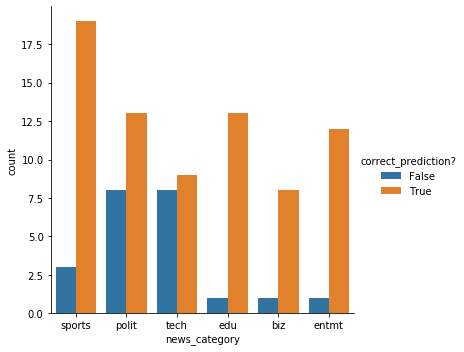

In [29]:
#plotting
import matplotlib.pyplot as plt
import seaborn as sns

review_test = news_test_data
review_test['actual'] = news_test_labels
review_test['predicted'] = news_pred
review_test["correct_prediction?"] = review_test.actual == review_test.predicted
sns.catplot(x="news_category", kind = "count", hue="correct_prediction?", data = review_test)
plt.show()